  # FSLD (Fast & Simple Label Diffusion)
### Fast community detection algorithm using a local and multi-level diffusion method in social networks

## Steps: 
### 1. Label diffusion step
### 2. Label updating step
### 3. Label diffusion to degree 1 nodes
### 4. Merge step

In [ ]:
!pip3 install cdlib

In [ ]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
from cdlib import algorithms, NodeClustering, evaluation
from sklearn import metrics
from cdlib.utils import convert_graph_formats, nx_node_integer_mapping
import datetime
from cdlib.algorithms.internal import DER
from cdlib.algorithms.internal.Kcut import kcut_exec
from cdlib.algorithms.internal.GDMP2_nx import GDMP2

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'karateclub', 'graph_tool', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


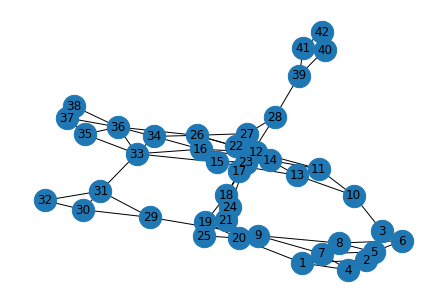

In [ ]:
path='./sample_data/'
filename='15rw_'
dataset='05' # dataset number
G=nx.Graph()   
edge_file= open(path+filename+'t'+str(dataset)+'.csv','r')
edge_list=edge_file.readlines()
max_node = -1
for edge in edge_list:
    edge=edge.split()
    G.add_node(int(edge[0]))
    G.add_node(int(edge[1]))
    G.add_edge(int(edge[0]), int(edge[1]))
    max_node = max(max_node, int(edge[0]))
    max_node = max(max_node, int(edge[1]))
G=G.to_undirected()

# GT
comm_file=open(path+filename+'comm_t'+str(dataset)+'.txt','r')
comm_list=comm_file.readlines()
comm_list = [[int(v) for v in line.split()] for line in comm_list]

# Print graph
nx.draw(G, with_labels=True, node_size=500)
plt.show()

## Step 1: Label assigning and diffusion for nodes with degree 2 and higher

In [ ]:
# Grouping of nodes according degrees
group_of_degrees = {}

for v in G:
    degree_of_v = G.degree(v)
    
    if degree_of_v not in group_of_degrees.keys():
        group_of_degrees[degree_of_v] = [v]
    else:
        group_of_degrees[degree_of_v].append(v)

print(group_of_degrees)

{3: [1, 6, 10, 9, 29, 19, 28, 39, 30, 35, 37, 40, 41], 4: [2, 4, 3, 7, 8, 11, 13, 17, 15, 34, 21, 27, 31], 5: [20, 14, 22, 18, 24], 6: [5, 12, 16, 26, 33, 23, 36], 2: [25, 32, 38, 42]}


In [ ]:
# Assigning label=0 to every node
zero_label_dict = {}
for v in G:
    zero_label_dict[v] = 0

nx.set_node_attributes(G, zero_label_dict, "label")

In [ ]:
# Helper Functions
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def get_label_of_node(node):
  return G.nodes[node]["label"]


def set_label_of_node(node, label):
  G.nodes[node]["label"] = label


def dcn(v, i):
    degree_v = G.degree(v)
    Nv = list(G.neighbors(v))
    Ni = list(G.neighbors(i))
    
    intersection_Nv_Ni = intersection(Nv, Ni)
    
    dcn_v_i = degree_v + 2*len(intersection_Nv_Ni)
    return dcn_v_i
  

def max_similarity_node_among_neighbors(target_node, target_node_neighbors):
    max_dcn = -1
    max_dcn_deg = -1
    # Here -1 value represents that, the node with maximum influence 
    # has not been found yet
    max_influence_neighbor_node = -1

    for neighbor in target_node_neighbors:
        dcn_v_i = dcn(target_node, neighbor)
        # -> If DCN of any 2 nodes are same, then we need to choose neighbour
        # -> w/ higher degree
        if max_dcn < dcn_v_i:
            max_dcn = dcn_v_i
            max_dcn_deg = G.degree(neighbor)
            max_influence_neighbor_node = neighbor
        elif max_dcn == dcn_v_i and max_dcn_deg < G.degree(neighbor):
            max_dcn_deg = G.degree(neighbor)
            max_influence_neighbor_node = neighbor


    return (max_influence_neighbor_node, max_dcn)


def diffuse_node_label(node, counter):
    node_neighbors = list(G.neighbors(node))
    
    # Check for Case 1: None of the neighbors are diffused
    all_neighbors_label_zero_flag = True
    for neighbor in node_neighbors:
      if get_label_of_node(neighbor):
        all_neighbors_label_zero_flag = False
        break;
    
    if all_neighbors_label_zero_flag:
      max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, node_neighbors)
      # We need to change the label of node and max_influence_node to new label
      counter+=1
      set_label_of_node(max_influence_neighbor_node, counter)
      set_label_of_node(node, counter)
      
      return counter
    
    # Check for Case 2 and 3: If any of the neighbors is 0 or not
    any_neighbor_label_zero_flag = False
    single_node_for_each_label_flag = True
    label_freq_dict = defaultdict(list)
    for neighbor in node_neighbors:
      neighbor_label = get_label_of_node(neighbor)
      if len(label_freq_dict[neighbor]) > 0:
        single_node_for_each_label_flag = False
      label_freq_dict[neighbor_label].append(neighbor)
    for label, neighbor_nodes in label_freq_dict.items():
      sorted_neighbor_nodes = sorted(neighbor_nodes, key = lambda x: G.degree(x))
      label_freq_dict[label] = sorted_neighbor_nodes
    if len(label_freq_dict[0]) > 0:
      any_neighbor_label_zero_flag = True

    # Case 2
    if any_neighbor_label_zero_flag == False:
      if single_node_for_each_label_flag:
        max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, node_neighbors)
        set_label_of_node(node, get_label_of_node(max_influence_neighbor_node))
      else:
        neighbors_with_highest_deg_for_each_label = []
        for label, neighbor_nodes in label_freq_dict.items():
          if len(neighbor_nodes) == 0:
            continue
          highest_deg_node = neighbor_nodes[len(neighbor_nodes) - 1]
          neighbors_with_highest_deg_for_each_label.append(highest_deg_node)
        
        max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, neighbors_with_highest_deg_for_each_label)
        set_label_of_node(node, get_label_of_node(max_influence_neighbor_node))
      return counter    



    # Case 3
    else:
      # get the higest freq labels and all its nodes
      _highest_label_freq = -1
      label_list = []
      for label, neighbor_nodes in label_freq_dict.items():
        if len(neighbor_nodes) > _highest_label_freq:
          label_list = [label] 
          _highest_label_freq = len(neighbor_nodes)
        elif len(neighbor_nodes) == _highest_label_freq:
          label_list.append(label)
      
      highest_deg_nodes_with_major_label = []
      for label in label_list:
        highest_deg_nodes_with_major_label.append(label_freq_dict[label][len(label_freq_dict[label])-1])
      
      highest_deg_nodes_with_major_label = sorted(highest_deg_nodes_with_major_label, key = lambda x: G.degree(x) )

      to_be_infused_node = highest_deg_nodes_with_major_label[len(highest_deg_nodes_with_major_label) -1 ]

      if get_label_of_node(to_be_infused_node) == 0:
        node_neighbors = list(G.neighbors(node))
        node_neighbors = sorted(node_neighbors, key = lambda x: G.degree(x) )
        node_neighbors.reverse()
        highest_deg_node_with_0_label = -1
        highest_deg_node_with_non_0_label = -1
        for n in node_neighbors:
          if highest_deg_node_with_0_label == -1 and get_label_of_node(n) == 0:
            highest_deg_node_with_0_label = n
          if highest_deg_node_with_non_0_label == -1 and get_label_of_node(n) == 0:
            highest_deg_node_with_non_0_label = n
          if highest_deg_node_with_non_0_label != -1 and highest_deg_node_with_0_label != -1:
            break

        if(dcn(node, highest_deg_node_with_non_0_label) > dcn(node, highest_deg_node_with_0_label)):
          set_label_of_node(node, get_label_of_node(highest_deg_node_with_non_0_label))
        else:
          counter+=1
          set_label_of_node(highest_deg_node_with_0_label, counter)
          set_label_of_node(node, counter)
        
      else: 
        set_label_of_node(node, get_label_of_node(to_be_infused_node))

      return counter    

In [ ]:
# Counter represents the label for next node
counter = 0
highest_degree = -1

for v in G:
  if G.degree(v) > highest_degree:
    highest_degree = G.degree(v)

for current_degree_level in range(2, highest_degree+1):
  if current_degree_level not in group_of_degrees:
    continue

  # Select target node
  current_degree_nodes = group_of_degrees[current_degree_level]

  for target_node in current_degree_nodes:
      # We need to only process a target_node if its label is 0 (not diffused)
      if get_label_of_node(target_node) == 0:
          counter = diffuse_node_label(target_node, counter)



## Step 2: Label updating of degree 2 and higher nodes

In [ ]:
# Helper functions for step 2
def update_node_label(target_node):
  neighbor_nodes = list(G.neighbors(target_node))
  neighbor_node_with_max_influence, _ = max_similarity_node_among_neighbors(target_node, neighbor_nodes)

  if get_label_of_node(target_node) != get_label_of_node(neighbor_node_with_max_influence):
    set_label_of_node(target_node, get_label_of_node(neighbor_node_with_max_influence))


In [ ]:
# Loop over all the degrees from highest to lowest till deg. 2 nodes
for current_degree_level in range(highest_degree, 1, -1):
  if current_degree_level not in group_of_degrees:
    continue

  # Select target node
  current_degree_nodes = group_of_degrees[current_degree_level]

  for target_node in current_degree_nodes:
      update_node_label(target_node)

## Step 3: Label diffusion to degree 1 nodes

In [ ]:
# As degree 1 nodes will be only connected to 1 direct neighbor
# It will be assigned the label of the neighbor

degree_1_nodes = group_of_degrees.get(1, [])

for node in degree_1_nodes:
  set_label_of_node(node, get_label_of_node(list(G.neighbors(node))[0]))


In [ ]:
# Printing labels of every node
initial_communities_dict = defaultdict(list)
for v in G:
  # print(f'Node: {v} label: {get_label_of_node(v)} ')
  initial_communities_dict[get_label_of_node(v)].append(v)

print()
print("Initial Communities")
for x in initial_communities_dict.keys():
  print(x, " : ", initial_communities_dict[x])


Initial Communities
5  :  [1, 2, 4, 5, 3, 6, 7, 8, 9]
1  :  [20, 19, 21, 24, 25]
14  :  [10, 11, 13, 14, 12, 17, 16, 22, 26, 15, 33, 34, 18, 23, 27, 28, 36, 35, 37, 38]
2  :  [29, 30, 31, 32]
4  :  [39]
11  :  [40, 41, 42]


## Step 4: Merge Step

In [ ]:
# TODO: Use this variable to merge newly formed communities 
# merge_iterations = 1 

# Change the initial_communities_dict to 
# arrange nodes in decreasing order of deg.
for label, nodes in initial_communities_dict.items():
  # sorts the nodes in increasing order
  nodes = sorted(nodes, key=lambda x: G.degree(x))
  # change the order to decreasing order
  nodes.reverse()
  initial_communities_dict[label] = nodes
final_communities_dict = initial_communities_dict

avg_community_size = len(list(G.nodes))/len(list(initial_communities_dict.keys()))
small_community_labels = []
large_community_labels = []

for label, nodes in initial_communities_dict.items():
  if len(nodes) >= avg_community_size:
    large_community_labels.append(label)
  else:
    small_community_labels.append(label)



In [ ]:
# Temporary: For printing out communities in graph diagram

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


Final Communities
5  :  [5, 8, 7, 3, 4, 2, 9, 6, 1]
1  :  [24, 20, 21, 19, 25]
14  :  [36, 23, 33, 26, 16, 12, 18, 22, 14, 27, 34, 15, 17, 13, 11, 37, 35, 28, 10, 38]
2  :  [31, 30, 29, 32]
4  :  [39]
11  :  [41, 40, 42]



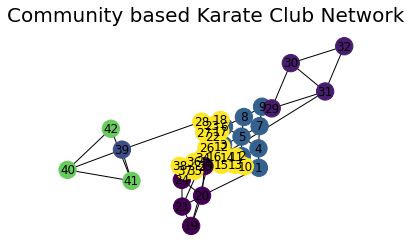

In [ ]:
print()
print("Final Communities")
for x in final_communities_dict.keys():
  print(x, " : ", final_communities_dict[x])

print()


partition = {}
for comm in final_communities_dict:
  for node in final_communities_dict[comm]:
    partition[node] = comm
pos = community_layout(G, partition)

node_color = []
for node in G.nodes():
  node_color.append(partition[node])

plt.title("Community based Karate Club Network", fontsize=20)
nx.draw(G,with_labels=True, pos=pos, node_color=node_color); 
plt.show()


In [ ]:
# Proven Algorithms
def label_propagation(g_original):
  g = convert_graph_formats(g_original, nx.Graph)

  coms = list(nx.algorithms.community.label_propagation_communities(g))
  coms_lpa = [list(x) for x in coms]
  
  return  coms_lpa
   
def greedy_modularity(g_original, weight=None):
  g = convert_graph_formats(g_original, nx.Graph)

  coms = nx.algorithms.community.greedy_modularity_communities(g, weight)
  coms = [list(x) for x in coms]

  return coms
        
def der(g_original, walk_len=3, threshold=.00001, iter_bound=50):
  graph = convert_graph_formats(g_original, nx.Graph)

  communities, _ = DER.der_graph_clustering(graph, walk_len=walk_len,
                                            alg_threshold=threshold, alg_iterbound=iter_bound)

  maps = {k: v for k, v in enumerate(graph.nodes())}
  coms = []
  for c in communities:
      coms.append([maps[n] for n in c])
  
  return coms

def gdmp2(g_original, min_threshold=0.75):
  """
  Gdmp2 is a method for identifying a set of dense subgraphs of a given sparse graph.
  It is inspired by an effective technique designed for a similar problem—matrix blocking, from a different discipline (solving linear systems).

  :param g_original: a networkx/igraph object
  :param min_threshold:  the minimum density threshold parameter to control the density of the output subgraphs, default 0.75
  :return: NodeClustering object
  :Example:
  >>> from cdlib import algorithms
  >>> import networkx as nx
  >>> G = nx.karate_club_graph()
  >>> com = algorithms.gdmp2(G)

  :References:

  Chen, Jie, and Yousef Saad. `Dense subgraph extraction with application to community detection. <https://ieeexplore.ieee.org/document/5677532/>`_ IEEE Transactions on Knowledge and Data Engineering 24.7 (2012): 1216-1230.

  .. note:: Reference implementation: https://github.com/imabhishekl/CSC591_Community_Detection
  """

  g = convert_graph_formats(g_original, nx.Graph)
  g, maps = nx_node_integer_mapping(g)

  coms = GDMP2(g, min_threshold)

  if maps is not None:
      communities = []
      for c in coms:
          communities.append([maps[n] for n in c])
      nx.relabel_nodes(g, maps, False)
  else:
      communities = coms
      
  return communities


def kcut(g_original, kmax=4):
  """
  An Efficient Spectral Algorithm for Network Community Discovery.
  Kcut is designed to provide a unique combination of recursive partitioning and direct k-way methods, able to guarantee the efficiency of a recursive approach, while also having the same accuracy as a direct k-way method.

  :param g_original: a networkx/igraph object
  :param kmax: maximum value of k, dafault 4.
  :return: NodeClustering object

  :Example:

  >>> from cdlib import algorithms
  >>> import networkx as nx
  >>> G = nx.head_tail()
  >>> coms = algorithms.kcut(G, head_tail_ratio=0.8)

  :References:

  Ruan, Jianhua, and Weixiong Zhang. "An efficient spectral algorithm for network community discovery and its applications to biological and social networks." Seventh IEEE International Conference on Data Mining (ICDM 2007). IEEE, 2007.

  .. note:: Reference implementation: https://github.com/hmliangliang/kcut-algorithm

  """

  g = convert_graph_formats(g_original, nx.Graph)
  coms = kcut_exec(g, kmax)
  return coms

In [ ]:
# Metrics

def get_scores(comm_our, comm_list_gt):
  actual=[]
  baseline=[]
  for j in range(len(comm_list_gt)):# groundtruth，j represents each community, j is the name of the community
    for c in comm_list_gt[j]: # Each node in the community represents each node
      flag=False
      for k in range(len(comm_our)): # Detected community, k is the name of the community
        if c in comm_our[k] and flag==False:
          flag=True 
          actual.append(j)
          baseline.append(k)
          break
  
  # NMI
  print('NMI', metrics.normalized_mutual_info_score(actual, baseline))

  # ARI
  print('ARI', metrics.adjusted_rand_score(actual, baseline))

  # Cut Ratio
  coms1 = NodeClustering(comm_our, G, "", overlap=False)
  condcc = evaluation.cut_ratio(G, coms1)
  print("Cut Ratio", condcc.score)

  # NGM
  coms1 = NodeClustering(comm_our, G, "", overlap=False)
  condcc = evaluation.newman_girvan_modularity(G, coms1)
  print("NGM", condcc.score)

  # Modularity
  edges = G.edges()
  m = len(edges)
  du = G.degree()
  # compute the edges in common community by node
  ret = 0.0
  for c in communities:
    for x in c:
      for y in c:
        if x <= y:
          if (x, y) in edges:
            aij = 1.0
          else:
            aij = 0.0
        else:
          if (y, x) in edges:
            aij = 1.0
          else:
            aij = 0
        tmp = aij - du[x] * du[y] * 1.0 / (2 * m)
        ret = ret + tmp
  ret = ret * 1.0 / (2 * m)
  print("Modularity", ret)
  
# DCC
print("DCC: ")
get_scores(communities, comm_list)
print("===================================================")

print("LPA: ")
lpa_comm=label_propagation(G)
get_scores(lpa_comm, comm_list)
print("===================================================")

print("GM: ")
gm_comm = greedy_modularity(G, None)
get_scores(gm_comm, comm_list)
print("===================================================")

print("DER: ")
der_comm= der(G, 3, .00001, 50)
get_scores(der_comm, comm_list)
print("===================================================")

print("Gdmp2: ")
gdmp2_comm=gdmp2(G, min_threshold=0.7)
get_scores(gdmp2_comm, comm_list)
print("===================================================")

print("Kcut: ")
kcut_comm=kcut(G, kmax=4)
get_scores(kcut_comm, comm_list)


DCC: 


NameError: ignored